<a href="https://colab.research.google.com/github/Kavehdkh/covid-data/blob/main/SIRmodel_multiobjective_3parts_brute_oneR0_constant_gamma_and_sigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from lmfit import Minimizer, Parameters, fit_report

import copy

from scipy import optimize


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import math

!pip install pandas_bokeh
import pandas_bokeh
pandas_bokeh.output_notebook()

     |████████████████████████████████| 1.0MB 4.5MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=2cbd949ef68cc276750e94a6c9f151ec0c7ce7d9ad53892847354accf3469d69
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3
     |████████████████████████████████| 266kB 4.6MB/s 
     |████████████████████████████████| 215kB 31.1MB/s 
     |████████████████████████████████| 256kB 28.9MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=d689560a32615893fce6c9c0aa30c14f9ed58c8183745969657fa798f58dfa6f
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.19-cp36-none-any.whl size=17486 sha256=09fb7c3fcde7fda3db520c59dc337ce0e359386a2b8323100d646e3fcc00a258
  Stored in directory: /root/.cache/pip/wheels/59/da/bf/62853db4291f1c5f91326e32e4d176

In [2]:
import random
random.seed(30)

In [4]:
#NOTE: set a random seed
# MODEL FUNCTION
#===============================================================================================================================================

#This is the derivate function. The function returns the change in any compartment at any given time that is defined for it
#y is the total population of any compartment
    #NOTE: by compartment we mean each section of the model (e.g. S for susceptible, is the total population of this compartment at any time t),
    #      the model can have many compartment as long as the related parameters are being defined for it
    
def deriv(y, t, N, beta, alpha,rho):
    S, E, I, Re, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - sigma * E
    dIdt = sigma * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRedt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRedt, dDdt

#The logsitic function smooth the trnasition of R0 over time
#def logistic_R_0(t):
#    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

#The Model function returns the array of population in any compartment 
def Model(day_start,day_end, total_population, R_0,alpha,rho, starting_data=[]):

    #start=0
    #The logsitic function smooth the trnasition of R0 over time
    #def logistic_R_0(t):
    #    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
    
    #Beta function returns the value of beta at any given time, Beta is not a constant number as it is dependant on the value of R0
    def beta(t):
        return R_0 * gamma
    
    N=total_population
    
    #Initial values of each compartment should be specfied manually, every single compartment should have an initial value
    S0, E0, I0, Re0, D0, I_cumulative_1_0, EtoI0, I_cumulative_20 = starting_data  # initial conditions: one exposed
    y0 = S0, E0, I0, Re0, D0 # Initial conditions vector
    
    #creating an array of time for integral function to perform integration process based on the interval we specifies here
    t = np.linspace(day_start, day_end-1, (day_end-day_start)) # Grid of time points (in days)

    #Integrating the SIR equations over the time grid, t. The function returns an array of values that is the total population of each compartment
    ret = odeint(deriv, y0, t, args=(N, beta, alpha,rho))
    
    #Assigning the results of intergration to its respective variable
    S, E, I, Re, D = ret.T
    
    #parameter will be used to demonstrate the transition in R0 over time
    #R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
    
    #We define a variable to represent the daily increase in the number of infected people, This is the array with the size of days
    EtoI= sigma * E
    
    #Cumulative number of cases
    #============================================================================================================================================
    # METHOD I
    #Cumulative number of infected people can also be defined as the total population minus the those leaving the susceptible compartment
    #I_cumulative_1 = N-S
   
    # METHOD II 
    # In this method, we compute the cumulative number of cases with the input of infected compartment
    # Creating a numpy array for the data of cumulative number of cases to be placed into
    #I_cumulative_2 = np.array(EtoI)

    # Creating a cumulative number of cases
    #for i in range(len(EtoI)):
    #    if i==0:
    #        I_cumulative_2[i]=I_cumulative_20
    #    else:
    #        I_cumulative_2[i]=EtoI[i]+I_cumulative_2[(i-1)]
    #I_cumulative = np.array(EtoI)
    I_cumulative = np.cumsum(EtoI)

    #============================================================================================================================================
    
    return t, S, E, I, Re, D, I_cumulative, EtoI #, I_cumulative_2#, R_0_over_time

In [5]:
# MODEL FITTING FUNCTION, Multi - Objective Version
#=======================================================================================================================================

# this model receives two sets of data and their counterpart in the model in the form of compartment number
# "compartment_train1" is the number of compartment within the model whcich will be used to fit the curve on the "training_data1"
def model_fitting_function_multi(training_data1,training_data1_cumulative, training_data2, outbreak_shift, compartment_train1, 
                                 compartment_train2,compartment_train3, initial_parameter, day_start,day_end,brute_step):

    # the data will be feed into the "data_adjust" function
    if outbreak_shift >= 0:
        adjusted_data1 = np.concatenate((np.zeros(outbreak_shift), training_data1))
        adjusted_data1_cumulative = np.concatenate((np.zeros(outbreak_shift), training_data1_cumulative))
        adjusted_data2 = np.concatenate((np.zeros(outbreak_shift), training_data2))
    else:
        adjusted_data1 = adjusted_data1[-outbreak_shift:]
        adjusted_data1_cumulative = adjusted_data1_cumulative[-outbreak_shift:]
        adjusted_data2 = adjusted_data2[-outbreak_shift:]
    
    #adjusted_data1 = data_adjust(train_data=training_data1, shift=outbreak_shift)
    #adjusted_data2 = data_adjust(train_data=training_data2, shift=outbreak_shift)
    #you need a check here to make sure they have the same length
    
    # data will transformed into an array format to be inserted into "multi_fit_objective" function
    y_data = []
    y_data = (adjusted_data1, adjusted_data1_cumulative, adjusted_data2) 
    y_data = np.array(y_data)
    
    # x_value is defined
    # x_value = adjusted_data1[0]
    x_value = np.linspace(day_start, day_end-1, (day_end - day_start))
    
    # time grid is defined
    #day = adjusted_data1[2] 
    
    # the desired compartments are assigned to its array
    compartment_array = [compartment_train1,compartment_train2,compartment_train3]
    
    # optimization function to minimize the residuals of the different data set
    
    fitter = Minimizer(multi_fit_objective, initial_parameter, 
                       fcn_args=(y_data, x_value, compartment_array))
    result = fitter.minimize(method='brute', Ns=brute_step, keep=brute_step)


    best_result = copy.deepcopy(result)
    for candidate in result.candidates:
        trial = fitter.minimize(method='leastsq', params=candidate.params)
        if trial.chisqr < best_result.chisqr:
            best_result = trial
    

    # the result is inserted into "estimate_data" function to get the estimated data for each compartment of the model
    estimited_data_result = estimate_data (model_fit_param = best_result.params)
    
    # plotting the graph estimated data vs. real data
    plot_curvefit_result(x_value=x_value, y_pred=estimited_data_result[5], y_true=adjusted_data2, title='Real Data vs Cumulative Death')
    plot_curvefit_result(x_value=x_value, y_pred=estimited_data_result[7], y_true=adjusted_data1, title='Real Data vs Number of Cases')
    plot_curvefit_result(x_value=x_value, y_pred=estimited_data_result[6],
                         y_true=adjusted_data1_cumulative, title='Real Data vs Cumulative Number of Cases')
    
    return estimited_data_result,best_result

In [6]:
# Objective function for multi-fitting curve function
#===============================================================================================================================================

#The structure of this section of the code has been retrieved from : 
#https://lmfit.github.io/lmfit-py/examples/example_fit_multi_datasets.html#sphx-glr-download-examples-example-fit-multi-datasets-py

def multi_fit_objective (initial_param, y_data, x_value, compartment_array):
   
    # this will give the dimension of the array (y_data)
    n_y_data, _ = y_data.shape
    
    #setting all element to zero
    resididuals = 0.0*y_data[:]
    
    estimated_data = estimate_data (model_fit_param=initial_param)

    # make residual per data set
    for i in range(n_y_data):
        
        # "y_data[i, :]" : the representation of the actual data 
        # "estimate_data (model...)" : the estimated data based on the paramters and the desired compartmental set in the model
        resididuals[i, :] = y_data[i, :] - estimated_data[compartment_array[i]]
        #resididuals[i, :] = resididuals[i, :]/max(resididuals[i, :])
    # now flatten this to a 1D array, as minimize() needs
    return resididuals.flatten()
 

In [7]:
# ACCURACY FUNCTION
#===============================================================================================================================================

#Creating a function to check the accuracy of estimates
def Accuracy_check(y_true,y_pred):
    
    #Mean Squared Error
    err_MSE2 = np.mean((y_true - y_pred)**2)
    
    #Mean Absolute Error
    err_MAE2 = np.mean(np.abs(y_true - y_pred))
    
    #Symmetric Mean Absolute Percentage Error
    #(https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)
    #First Version
    #err_SMAPE2 = np.mean(np.abs(y_true - y_pred)/((np.abs(y_true)+np.abs(y_pred))/2))*100
    #third Version
    err_SMAPE2 = sum(np.abs(y_true - y_pred))/sum(y_true+y_pred)
    
    #Mean Absolute Scaled Error
    MASE_data2=np.zeros(len(y_true)-1)
    for i in range(1,len(y_true)):
        MASE_data2[(i-1)]=np.abs(y_pred[i]-y_pred[(i-1)])
    err_MASE2 = np.mean(MASE_data2)/((len(y_true))-1)

    error_result2= [err_MAE2,err_MSE2,err_SMAPE2,err_MASE2]
    
    return error_result2


In [8]:
# PLOTTING FUNCTION
#===============================================================================================================================================

# Plot the real data vs the fitted data
#the ratio is the number which the data will be divided by
def plot_curvefit_result(x_value,y_pred,y_true,title):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    #Normalizing the values of the real and fitted data for better representation
    ax.plot(x_value, y_pred/(max(np.max(y_pred),np.max(y_true))), 'b', alpha=0.5, lw=2, label='Fitted data')
    ax.plot(x_value, y_true/(max(np.max(y_pred),np.max(y_true))), 'r', alpha=0.5, lw=2, label='Real data')
    #ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of')
    
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title(title)
    plt.show();

In [21]:
# ESTIMATED DATA FUNCTION
#===============================================================================================================================================

# Creating a function that recieves the parameters for the model, 
# Returing a matrix of result for each compartment based on the best values of parameters that model estimated

#model_fit_param=initial_param,day_start=day_start,day_end=day_end,starting_data=starting_data

def estimate_data (model_fit_param):
    
    model_fit_data = Model(day_start = day_start,
                           day_end   = day_end,
                           total_population = total_population, 
                           R_0 = model_fit_param["R_0"],
                           alpha     = model_fit_param["alpha"],
                           rho       = model_fit_param["rho"],
                           starting_data = starting_data)
    return model_fit_data
  #k         = model_fit_param["k"],

In [11]:
#DATA ADJUSTMENT
#===========================================================================================

def data_adjust(train_data,shift):
    #this is a delay in the outbreak of the pandemic, it will be different for different region
    #outbreak_shift=0

    # >>>>>>>> CHOOSE ONE OF THE FOLLOWING TWO ARGUMENTS <<<<<<<<
    #Assign one of the data set to the variable, 
    #train_data = training_set1_cumulative
    #train_data = training_set1
    #train_data = training_set2

    #creating the length of the model base on the length of the available data
    days = len(train_data)+shift
    #day_start = day_start + shift
    #day_end   = day_end  +  shift
    
    #Creating interval for the addition of outbreak shift
    #this section needs further exploration
    if shift >= 0:
        y_data = np.concatenate((np.zeros(shift), train_data))
    else:
        y_data = y_data[-shift:]

    #Creating time grid for model fitting
    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days-1] array
    
    return x_data,y_data,days

### Region's Data:

In [12]:
# POPULATION OF THE REGION
#===============================================================================================================================================

#The initial population of targeted region needs to be specified
population_Region = 5147712 #Q3 estimate of BC population (https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901)

#it will then needs to be assigned to the total population that model receives 
total_population= population_Region

In [13]:
# DATA RETRIEVAL FUNCTION, PART I
#===============================================================================================================================================

#Inserting the "REAL" data into the model
#This file has been retrieved from: http://www.bccdc.ca/health-info/diseases-conditions/covid-19/data

#raw_data = pd.read_csv(path)

raw_data=pd.read_csv('https://raw.githubusercontent.com/Kavehdkh/covid-data/main/BCCDC_COVID19_Dashboard_Case_Details.csv')

#Creating a data frame with only the reported date
report_date=pd.DataFrame(raw_data['Reported_Date'])

#Counting the number of reported date and creating a data frame with number of daily cases
daily_cases=report_date.groupby(report_date.columns.tolist()).size().reset_index().\
    rename(columns={0:'Cases'})

#removing the previous index set by the original file
daily_cases = daily_cases.reset_index()

#setting the reported date into date format
daily_cases['Reported_Date'] = pd.to_datetime(daily_cases['Reported_Date'],format='%Y-%m-%d')

#setting the range of data based on the starting and end date of the available data, which willbe used as an index to fill the gap
idx_1 = pd.date_range(min(daily_cases['Reported_Date']),max(daily_cases['Reported_Date']))
#idx = pd.date_range('01-26-2020', '10-16-2020')

#setting the index  of data based on the date column of data
daily_cases.set_index(daily_cases.Reported_Date, inplace=True)

#filling the missing data with zeros
daily_cases = daily_cases.reindex(idx_1, fill_value=0)

#Droping the extra columns
daily_cases = daily_cases.drop(columns=['Reported_Date','index'])

#Creating the array of data, in this section we assign the value of desired data into an array
daily_cases = daily_cases["Cases"].values[::1]

In [14]:
daily_cases

array([  1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   2,   0,   0,
         0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         1,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   4,   6,
         4,   6,   1,   3,   5,  11,  20,  12,  25,  12,  28,  46,  41,
        60,  47,  62,  46,  43,  88,  59,  91,  62,  62,  37,  30,  82,
        56,  47,  55,  31,  21,  13,  51,  40,  33,  34,  41,  28,  15,
        30,  44,  14,  51,  25,  30,  15,  34,  63,  33,  37,  72,  61,
        15,  58,  41,  27,  29,  23,  33,  21,  16,  24,  29,  21,  14,
         8,  17,  10,  13,  16,  14,  21,   8,  11,   5,  19,  11,  22,
        12,   4,   9,   8,   7,  10,   5,  11,   9,  16,   4,  23,   2,
         4,  12,   7,   9,  10,  14,  12,  17,  14,  14,   9,  11,  19,
         9,   5,   9,   6,  17,  11,  12,  21,  12,   9,  13,   3,  12,
        17,  10,   9,  12,  16,   7,  10,  19,  18,  22,  25,  23,  20,
        13,  19,  24,  33,  44,  19,  29,  33,  34,  32,  30,  3

In [15]:
# DATA RETRIEVAL FUNCTION, PART II
#===============================================================================================================================================

#Importing and cleaning data
#This section needs input from the user
#======================================================================================================================================
#importing the entire data set for canadian number of cases and deaths
#This file has been retrieve from: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html 
comp_data = pd.read_csv('https://raw.githubusercontent.com/Kavehdkh/covid-data/main/covid19-Complete%20Data%20Canada.csv')

#this is the range of data on which we want to perform the analysis on
idx = pd.date_range('01-26-2020', '10-09-2020')

#which provience do you want to do the analysis on:
provience='British Columbia'

#percentage format can be set up as well, the following code can be used for this purpose
#the other line needs to be activated further in the code
#percentage_train_set=80

#======================================================================================================================================

#Filtering the data for number of deaths, you can choose different category from the data
#prname : province name
modified_data=comp_data.filter(items=['prname', 'date','numdeaths'])

#Filtering the data for the specific region
provincial_data=modified_data.loc[modified_data['prname'] == provience]

#removing the previous index set by the original file
provincial_data = provincial_data.reset_index()

#assigning the date column into date format, this is important to do so that the model knows the data is based on specific series
provincial_data['date'] = pd.to_datetime(provincial_data['date'],format='%Y-%m-%d')

#setting the range of data based on the starting and end date of the available data, which willbe used as an index to fill the gap
idx_2 = pd.date_range(min(provincial_data['date']),max(provincial_data['date']))

#setting the index  of data based on the date column of data
provincial_data.set_index(provincial_data.date, inplace=True)

#filling the missing data with zeros
provincial_data = provincial_data.reindex(idx_2, fill_value=0)

#Droping the extra columns
provincial_data = provincial_data.drop(columns=['date','index','prname'])

#Creating the array of data, in this section we assign the value of desired data into an array
provincial_data = provincial_data["numdeaths"].values[::1]

In [16]:
# DATA SET CREATION
#===============================================================================================================================================

def data_set_create(Start_day_training,end_day_training):
    
    # daily_cases     : complete data array of daily cases
    # provincial_data : complete data array of cumulative death

    #available number of days in the data, it should be minimum of length of available data set
    day_available=min(len(daily_cases),len(provincial_data))

   # length of trainging set:
   #===============================================================================
   # Method I
   #it can be a percentage of the available data:
   #training_length=math.ceil(day_available*percentage_train_set/100)
   # Method II
   # it can be assigned directly:
   #Start_day_training = 0
   #end_day_training = 120 

   #Creating an array of data, in this case the daily number of infected people. 
   #This array should only have one column of the desired target


   # Creating number of cases
   #===============================================================================
   #Creating a numpy array for cumulative data to be placed into
    cumulative_cases_data = np.array(daily_cases)

  #Creating a cumulative number of cases
    for i in range(len(daily_cases)):
            if i==0:
                cumulative_cases_data[i]=daily_cases[i]
            else:
                cumulative_cases_data[i]=daily_cases[i]+cumulative_cases_data[(i-1)]           


  # DATA SET ASSIGNMENT
  #===============================================================================
  # TRAINING SET
    training_set1 = daily_cases [Start_day_training:end_day_training]
    training_set1_cumulative = cumulative_cases_data [Start_day_training:end_day_training]
    training_set2 = provincial_data [Start_day_training:end_day_training]


  # TEST SET
    test_set1 = daily_cases[(end_day_training):day_available]
    test_set1_cumulative = cumulative_cases_data [(end_day_training+1):day_available]
    test_set2 = provincial_data[(end_day_training):day_available]

    return training_set1, training_set1_cumulative, training_set2, test_set1, test_set1_cumulative, test_set2,day_available

In [17]:
# plotting the data
#===============================================================================
#plt.plot(daily_cases)
#plt.show()
Starting_day=0
ending_day=180
data_set1=data_set_create(Start_day_training=Starting_day,end_day_training=ending_day)

training_set1 = data_set1[0]
training_set1_cumulative = data_set1[1]
training_set2 = data_set1[2]


  # TEST SET
test_set1 = data_set1[3]
test_set1_cumulative = data_set1[4]
test_set2 = data_set1[5]


len(training_set2)

180

In [18]:
Names = ['days',
         'Susceptible',
         'Exposed',
         'Infectious',
         'Recovered',
         'Dead',
         'Cumulative number of cases',
         'Daily Number of cases',
         'Real Number of Cases',
         'Real Cumulative Number of Cases',
         'Real Cumulative Number of Death']

In [19]:
# Data Frame Transformation Function
#===========================================================================================================

#This function recives the entire results of the curve fitting function and transform it into dataframe
#The real data sets were defined before running the curve fitting function
#This function add the latest version of the real data set

def dataframe_transform(Result_curve_fitting):
    
#Trnasforming the result into a list
    Result_list=list(Result_curve_fitting[0])

  #Creating an array of real data
    Real_data = np.array((training_set1,training_set1_cumulative,training_set2))

  #Joining the real data and result into one array
    final_result_real_array=np.concatenate((Result_list, Real_data))

  #Trnasforming the the final array into a dataframe
    final_result_real_dataframe=(pd.DataFrame(final_result_real_array).T)

  #Assiging associate name for each column
    final_result_real_dataframe.columns=Names

    return final_result_real_dataframe

In [ ]:

params_init_min_max = Parameters()
params_init_min_max.add("R_0_start",    min = 1.5,    max = 10.0   )
params_init_min_max.add("k",            min = 0.01,   max = 50.0   )
params_init_min_max.add("x0",           min = 0,      max = 120    )
params_init_min_max.add("R_0_end",      min = 0.3,    max = 10.0   )
params_init_min_max.add("gamma",        min = 0.01,   max = 0.4    )
params_init_min_max.add("sigma",        min = 0.1,    max = 0.6    )
params_init_min_max.add("alpha",        min = 0.01,   max = 0.04   )
params_init_min_max.add("rho",          min = 0.05,   max = 0.25   )



params_init_min_max = Parameters()
params_init_min_max.add("R_0_start",  value = 3.63,   min = 1.5,    max = 10.0   )
params_init_min_max.add("k",          value = 50,    min = 0.01,   max = 50.0   )
params_init_min_max.add("x0",         value = 58,    min = 0,      max = 120    )
params_init_min_max.add("R_0_end",    value = 1.0,  min = 0.3,    max = 3.5    )
params_init_min_max.add("gamma",      value = 0.08,  min = 0.01,   max = 0.2    )
params_init_min_max.add("sigma",      value = 0.22,  min = 0.01,   max = 0.8    )
params_init_min_max.add("alpha",      value = 0.012,  min = 0.003,  max = 0.04   )
params_init_min_max.add("rho",        value = 0.13,  min = 0.1,    max = 0.5    )

name,value,initial value,min,max,vary
R_0_start,1.50000000,None,1.50000000,10.0000000,True
k,0.01000000,None,0.01000000,50.0000000,True
x0,0.00000000,None,0.00000000,120.000000,True
R_0_end,0.30000000,None,0.30000000,3.50000000,True
gamma,0.01000000,None,0.01000000,0.20000000,True
sigma,0.01000000,None,0.01000000,0.80000000,True
alpha,0.00300000,None,0.00300000,0.04000000,True
rho,0.10000000,None,0.10000000,0.50000000,True


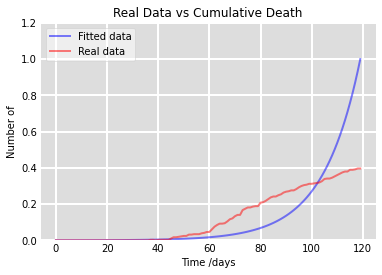

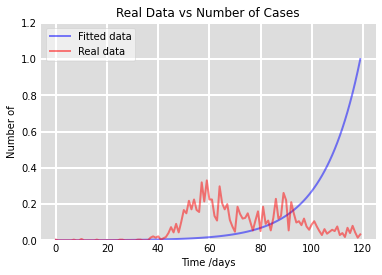

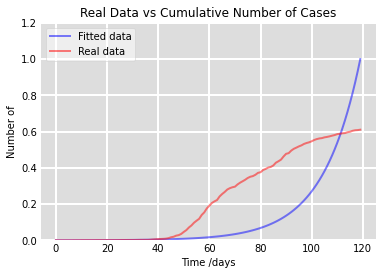

In [27]:
# SECTION 1
#========================================================================================================================
#fitting the curve on the first 120 days of pandemic

#Creating initial guesses and upper and lower bound for the parameters that model needs to estimate

params_init_min_max = Parameters()
#params_init_min_max.add("R_0_start",   min = 1.5,    max = 10.0   )
params_init_min_max.add("R_0",   min = 0.01,    max = 10.0   )
#params_init_min_max.add("x0",          min = 0,      max = 120    )
#params_init_min_max.add("k",            min = 0.01,   max = 50.0  )
#params_init_min_max.add("R_0_end",     min = 0.3,    max = 10     )
#params_init_min_max.add("gamma",       min = 0.01,   max = 0.2    )
params_init_min_max.add("alpha",       min = 0.003,  max = 0.5   )
params_init_min_max.add("rho",         min = 0.01,    max = 4.0    )

k=1.0
#rho=0.13
sigma=1/5
gamma=1/12.5

# setting the initial values of each compartment
start_point_1 = [population_Region,1,0,0,0,0,0,0]
starting_data = start_point_1

# setting up the date on which the curve fitting function will be perfomed
Start_day_training = 0
end_day_training = 120

# creating data set based on the specified interval
data_set=data_set_create(Start_day_training=Start_day_training, end_day_training=end_day_training)

# this is important to have it like this format since these variables will be used throughout the model
training_set1 = data_set[0]
training_set1_cumulative = data_set[1]
training_set2 = data_set[2]
day_start=Start_day_training
day_end=end_day_training


# perfoming the curve fitting function
Result_curve_fitting_1=model_fitting_function_multi(training_data1 = training_set1,
                                   training_data1_cumulative = training_set1_cumulative,
                                   training_data2 = training_set2, 
                                   outbreak_shift = 0,
                                   compartment_train1 = 7,
                                   compartment_train2 = 6,
                                   compartment_train3 = 5,
                                   initial_parameter= params_init_min_max,
                                   day_start=Start_day_training,
                                   day_end=end_day_training,
                                   brute_step=10)

# Creating a data frame of result and real data
dataframe_result_1 = dataframe_transform(Result_curve_fitting=Result_curve_fitting_1)

In [ ]:
2**3

8

In [ ]:
Result_curve_fitting_1[1]

In [ ]:
Result_curve_fitting_1[1]

In [ ]:
Result_curve_fitting_1[1]

In [ ]:
params_init_min_max

name,value,initial value,min,max,vary
R_0_start,1.50000000,None,1.50000000,10.0000000,True
x0,0.00000000,None,0.00000000,120.000000,True
R_0_end,0.30000000,None,0.30000000,10.0000000,True
sigma,0.01000000,None,0.01000000,0.80000000,True
alpha,0.00300000,None,0.00300000,0.04000000,True


In [ ]:
par_name = 'x0'
indx_shift = result_brute.var_names.index(par_name)
grid_shift = np.unique(result_brute.brute_grid[indx_shift].ravel())
print("parameter = {}\nnumber of steps = {}\ngrid = {}".format(par_name,
                                                               len(grid_shift),
                                                               grid_shift))


NameError: ignored

In [ ]:
Result_curve_fitting_1[1]

In [ ]:
resultbrute=Result_curve_fitting_1[1]
resultbrute.brute_grid.shape

(5, 7, 7, 7, 7, 7)

In [ ]:
Result_curve_fitting_1[1].params

name,value,initial value,min,max,vary
R0,10.0000000,None,1.50000000,10.0000000,True
gamma,0.01000000,None,0.01000000,0.20000000,True
sigma,0.40500000,None,0.01000000,0.80000000,True
alpha,0.04000000,None,0.00300000,0.04000000,True
rho,0.50000000,None,0.10000000,0.50000000,True


In [ ]:
Result_curve_fitting_1[1].params

name,value,initial value,min,max,vary
R0,10.0000000,None,1.50000000,10.0000000,True
gamma,0.01000000,None,0.01000000,0.20000000,True
sigma,0.27333333,None,0.01000000,0.80000000,True
alpha,0.04000000,None,0.00300000,0.04000000,True
rho,0.36666667,None,0.10000000,0.50000000,True


In [ ]:
Result_curve_fitting_1[1].params

name,value,initial value,min,max,vary
R_0_start,10.0000000,None,1.50000000,10.0000000,True
k,25.0050000,None,0.01000000,50.0000000,True
x0,120.000000,None,0.00000000,120.000000,True
R_0_end,0.30000000,None,0.30000000,3.50000000,True
gamma,0.01000000,None,0.01000000,0.20000000,True
sigma,0.40500000,None,0.01000000,0.80000000,True
alpha,0.04000000,None,0.00300000,0.04000000,True
rho,0.50000000,None,0.10000000,0.50000000,True


In [ ]:
Result_curve_fitting_1[1].params

name,value,initial value,min,max,vary
R_0_start,10.0000000,None,1.50000000,10.0000000,True
k,0.01000000,None,0.01000000,50.0000000,True
x0,120.000000,None,0.00000000,120.000000,True
R_0_end,3.50000000,None,0.30000000,3.50000000,True
gamma,0.01000000,None,0.01000000,0.20000000,True
sigma,0.80000000,None,0.01000000,0.80000000,True
alpha,0.04000000,None,0.00300000,0.04000000,True
rho,0.50000000,None,0.10000000,0.50000000,True


In [ ]:
Result_curve_fitting_1[1].params

name,value,standard error,relative error,initial value,min,max,vary
R_0_start,4.55705366,5990.65163,(131458.88%),3.63,1.50000000,10.0000000,True
k,18.7875713,21735.2727,(115689.64%),50,0.01000000,50.0000000,True
x0,57.4877667,3.83530402,(6.67%),58,0.00000000,120.000000,True
R_0_end,0.90465701,1189.32267,(131466.69%),0.82,0.30000000,3.50000000,True
gamma,0.07353998,96.6732899,(131456.78%),0.08,0.01000000,0.20000000,True
sigma,0.18006379,0.07911736,(43.94%),0.22,0.01000000,0.80000000,True
alpha,0.01547067,1294.32178,(8366295.14%),0.012,0.00300000,0.04000000,True
rho,0.36062774,30171.2127,(8366303.88%),0.13,0.10000000,0.50000000,True


In [ ]:
# Using the parameters of the section 1 to adjust those for the section 2
Result_curve_fitting_1[1].params

name,value,standard error,relative error,initial value,min,max,vary
R_0_start,3.63229910,374.121432,(10299.85%),7.0,1.50000000,10.0000000,True
k,49.9838179,781667.874,(1563841.87%),20,0.01000000,50.0000000,True
x0,58.7622570,3.03608354,(5.17%),87,0.00000000,120.000000,True
R_0_end,0.82144966,84.3875147,(10273.00%),3.48,0.30000000,3.50000000,True
gamma,0.08782673,9.04508953,(10298.79%),0.14,0.01000000,0.20000000,True
sigma,0.22612078,0.10461939,(46.27%),0.06,0.01000000,0.80000000,True
alpha,0.01280349,101.444467,(792318.66%),0.02,0.00300000,0.04000000,True
rho,0.49999736,4071.41254,(814286.80%),0.13,0.10000000,0.50000000,True


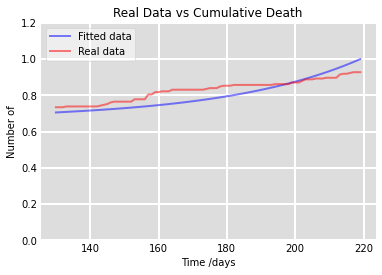

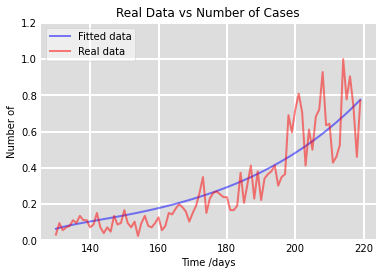

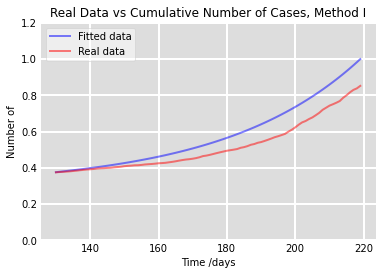

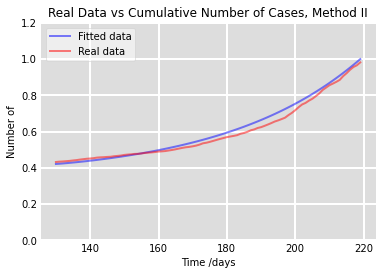

In [ ]:
# SECTION 2
#========================================================================================================================
#fitting the curve on the first 120 days of pandemic

#Creating initial guesses and upper and lower bound for the parameters that model needs to estimate


#adjusting the parameters, (specificly the R0) for the second part
params_init_min_max = Parameters()
params_init_min_max.add("R_0_start",  value = 0.8,   min = 0.2,    max = 10.0   )
params_init_min_max.add("k",          value = 50,    min = 0.01,   max = 50.0   )
params_init_min_max.add("x0",         value = 60,    min = 0,      max = 120    )
params_init_min_max.add("R_0_end",    value = 4,  min = 0.3,    max = 10.0   )
params_init_min_max.add("gamma",      value = 0.14,  min = 0.01,   max = 0.2    )
params_init_min_max.add("sigma",      value = 0.2,  min = 0.01,   max = 0.8    )
params_init_min_max.add("alpha",      value = 0.02,  min = 0.003,  max = 0.04   )
params_init_min_max.add("rho",        value = 0.13,  min = 0.1,    max = 0.8    )



params_init_min_max = Parameters()
params_init_min_max.add("R_0_start",  value = 0.8,   min = 0.6,    max = 10.0   )
params_init_min_max.add("k",          value = 20,    min = 0.01,   max = 50.0   )
params_init_min_max.add("x0",         value = 87,    min = 0,      max = 120    )
params_init_min_max.add("R_0_end",    value = 4,     min = 0.3,    max = 10.0   )
params_init_min_max.add("gamma",      value = 0.2,   min = 0.01,   max = 0.4    )
params_init_min_max.add("sigma",      value = 0.3,   min = 0.1,    max = 0.6    )
params_init_min_max.add("alpha",      value = 0.03,  min = 0.01,   max = 0.06   )
params_init_min_max.add("rho",        value = 0.13,  min = 0.01,   max = 0.2    )


#Assiging the values of last entry in each compartment as the starting value foe the second graph
start_point_2=dataframe_result_1.iloc[119,1:9]
starting_data = start_point_2


# setting up the date on which the curve fitting function will be perfomed
Start_day_training = 130
end_day_training = 220


# creating data set based on the specified interval
data_set=data_set_create(Start_day_training=Start_day_training, end_day_training=end_day_training)

# this is important to have it like this format since these variables will be used throughout the model
training_set1 = data_set[0]
training_set1_cumulative = data_set[1]
training_set2 = data_set[2]
day_start=Start_day_training
day_end=end_day_training


# perfoming the curve fitting function
Result_curve_fitting_2 = model_fitting_function_multi(training_data1 = training_set1,
                                                      training_data1_cumulative = training_set1_cumulative,
                                                      training_data2 = training_set2, 
                                                      outbreak_shift = 0,
                                                      compartment_train1 = 7,
                                                      compartment_train2 = 5,
                                                      initial_parameter = params_init_min_max,
                                                      day_start = Start_day_training,
                                                      day_end = end_day_training)

# Creating a data frame of result and real data
dataframe_result_2 = dataframe_transform(Result_curve_fitting=Result_curve_fitting_2)

In [ ]:
# SECTION 3
#===================================================================================================================
# using the parameters from section 2 to estimate each compartment for the test set and beyond

start_point_3=dataframe_result_2.iloc[89,1:9]
starting_data = start_point_3
#initial_value_compart=start_point_3
#starting_data = initial_value_compart

Start_day_training = 220
end_day_training = 300

data_set=data_set_create(Start_day_training=Start_day_training, end_day_training=end_day_training)

training_set1 = data_set[0]
training_set1_cumulative = data_set[1]
training_set2 = data_set[2]

day_start=Start_day_training
day_end=end_day_training

#using the estimate function and passing the paramaters found on the traning set, we can find the data in the test set
Result_curve_fitting_3 = estimate_data (model_fit_param=Result_curve_fitting_2[1].params)

# Creating a data frame for the result
Real_data_frame_3=pd.DataFrame(list(np.array((training_set1,training_set1_cumulative,training_set2)))).T
Result_data_frame_3=pd.DataFrame(list(Result_curve_fitting_3)).T
dataframe_result_3=(pd.concat([Result_data_frame_3, Real_data_frame_3], axis=1, sort=False))#.fillna(0)  #you can use this to replace NaN with zeros
dataframe_result_3.columns=Names

In [ ]:
# Creating a data frame of all results

final_result = pd.concat([dataframe_result_1,dataframe_result_2,dataframe_result_3], ignore_index=True, sort=False)

In [ ]:
#         'days',
#         'Susceptible',
#         'Exposed',
#         'Infectious',
#         'Recovered',
#         'Dead',
#         'Cumulative number of cases, Method I',
#         'Daily Number of cases',
#         'Cumulative number of cases, Method II',
#         'Real Number of Cases',
#         'Real Cumulative Number of Cases',
#         'Real Cumulative Number of Death']

final_result.plot_bokeh(
    figsize=(800, 500),
    zooming=False,
    panning=False,
    legend="top_left",
    kind='line',
    x='days',
    y=['Real Cumulative Number of Death','Dead'],
    xlabel='day',
    ylabel='Population',
    title='SIR MODEL',
    xticks=range(Start_day_training,end_day_training,50),
    show_figure=True,
    toolbar_location=None)

Figure(id='4789', ...)

In [ ]:
p_dead = final_result.plot_bokeh(
    zooming=False,
    panning=False,
    legend="top_left",
    kind='line',
    x='days',
    y=['Dead','Real Cumulative Number of Death'],
    xlabel='Category',
    ylabel='Population',
    title='SIR MODEL',
    xticks=range(0,200,20),
    show_figure=False)
p_cases = final_result.plot_bokeh(
    zooming=False,
    panning=False,
    legend="top_left",
    kind='line',
    x='days',
    y=['Daily Number of cases','Real Number of Cases'],
    xlabel='Category',
    ylabel='Population',
    title='SIR MODEL',
    xticks=range(0,200,20),
    show_figure=False)
p_cases_cumulative = final_result.plot_bokeh(
    figsize=(1000, 500),
    zooming=False,
    panning=False,
    legend="top_left",
    kind='line',
    x='days',
    y=['Cumulative number of cases, Method II','Cumulative number of cases, Method I','Real Cumulative Number of Cases'],
    xlabel='Category',
    ylabel='Population',
    title='SIR MODEL',
    xticks=range(0,200,20),
    show_figure=True)

pandas_bokeh.plot_grid([[p_dead,p_cases]])

Column(id='5603', ...)